<a href="https://colab.research.google.com/github/kachytronico/colab-PIA/blob/main/BDA_TAREA_01_Alfredo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BDA01 - Tarea de Evaluación: Proyecto ETL de Riesgo Genético para Diabetes Tipo 1 (T1D)

## Importación de librerías necesarias para todo el proyecto



In [1]:
# 2. Carga de Datos al Servidor
# Importamos la librería principal que necesitamos para trabajar con tablas de datos (DataFrames).
import pandas as pd

# 3.4. Detección Visual de Atípicos (boxplot)
#---------------------------------------------
# Importamos NumPy, que es útil si el código de seaborn lo necesita.
#import numpy as np
# Importamos las librerías necesarias para la visualización.
import matplotlib.pyplot as plt
import seaborn as sns

# 4.1. Aplicación de StandardScaler
# Importamos la librería para el escalado estándar (StandardScaler)
# Es la función clave que utiliza la media y la desviación típica.
from sklearn.preprocessing import StandardScaler

# 5.1. Limpieza de Outliers y Estandarización de Variables
# Importamos numpy para el manejo de valores nulos (np.nan)
import numpy as np


## I. CONFIGURACIÓN, EXPLICACIÓN Y EXTRACCIÓN (E)

Esta primera sección establece el entorno, justifica mi elección de datos y define el método para la fase de **Extracción (E)** del proceso ETL, cubriendo los apartados 1 y 2 de la tarea.



### 1.- Explicación del Conjunto de Datos Elegido (1 Punto)

**Temática y Atractivo Personal:**

He decidido enfocar mi proyecto ETL en el análisis del **riesgo genético de la Diabetes Tipo 1 (T1D)**, utilizando datos de un estudio clínico real llamado **Virginia PrIMeD**. Este tema me resulta especialmente atractivo porque, como persona con diabetes, me interesa muchísimo ver cómo podemos usar las herramientas de **Big Data** para analizar las complejas interacciones genéticas detrás de esta enfermedad autoinmune. Mi meta es transformar esta data cruda en información útil que pueda sentar las bases para modelos de detección de riesgo.

**Volumen, Multiplicidad y Relación de los Datos:**

Para este análisis, no he usado solo un archivo, sino **tres conjuntos de datos interrelacionados** que se complementan entre sí, algo crucial para el enriquecimiento de datos. Los tres archivos suman en total unos **3.800 registros**, cumpliendo con el requisito de trabajar con un volumen significativo pero manejable para esta unidad.

1.  **Datos de la Encuesta (`survey_data` - Fenotipo):** Este es mi archivo **principal**. Contiene la información demográfica y clínica de los participantes. Las columnas clave son: el identificador único del sujeto (**`SUBJECT_ID`**), la **`AGE`**, la **`RACE`**, si ha habido historial familiar de T1D (**`T1D_HIST`**) y el diagnóstico final (**`T1D_DIAG`**). Lo más importante son las puntuaciones de riesgo genético (GRS) ya calculadas: **`GRS_HLA`**, **`GnonHLA`** y el **`GRS`** total, además de la clasificación de riesgo (**`Risk`**).

2.  **Datos de Genotipado (`genotyping_file` - Genética):** Este archivo contiene los datos genéticos puros. Aquí es donde encuentro los alelos específicos (**SNPs**, como `A:G`, `C:C`, etc.) para más de 70 marcadores genéticos (columnas con prefijo `rs...`). Este detalle genético será esencial más adelante para la reducción de datos. Su clave para relacionarse es **`FID`**, que contiene el mismo valor que el **`SUBJECT_ID`** del archivo principal.

3.  **Lista de Pesos de SNPs (`SNP_list` - Metadatos):** Este archivo funciona como una tabla de **enriquecimiento**. Contiene la lista de los SNPs y sus respectivos **`Weight`** (pesos o coeficientes de riesgo), que se usaron para calcular las puntuaciones GRS.

La **Relación** se establece a través del identificador de participante: el campo **`SUBJECT_ID`** en el archivo principal y el campo **`FID`** en el archivo de genotipado. Esto me asegura que puedo integrar sin problemas los datos clínicos con los datos genéticos.

### 2.- Carga de Datos al Servidor (1 Punto)

**Entorno y Método Preferente:**

Mi entorno de trabajo es **Google Colab**. Para garantizar el punto completo y facilitar la ejecución de mi cuaderno de principio a fin sin necesidad de subir archivos manualmente, voy a cargar los datos directamente desde sus **rutas URL de GitHub**. Esto cumple con el método preferente solicitado por el tutor.

In [2]:

# Rutas RAW de los archivos Excel en GitHub
# Usamos pd.read_excel(), que maneja mejor los formatos de número que vienen de Excel.
URL_GENOTYPING = 'https://github.com/kachytronico/Cursos-Colab-BDA/raw/main/Dataset%20not%20incorporated%20into%20the%20T1DKP/assay_final_genotyping_file.xlsx'
URL_SURVEY = 'https://github.com/kachytronico/Cursos-Colab-BDA/raw/main/Dataset%20not%20incorporated%20into%20the%20T1DKP/survey_data_and_results_final.xlsx'
URL_SNP_LIST = 'https://github.com/kachytronico/Cursos-Colab-BDA/raw/main/Dataset%20not%20incorporated%20into%20the%20T1DKP/TableS1_TID%20GRS%20SNP%20List.xlsx'

print("--- Iniciando la fase de EXTRACCIÓN (E) de datos desde GitHub (vía Excel) ---")

# 1. Cargar el DataFrame de Genotipado
genotyping_df = pd.read_excel(URL_GENOTYPING)

# 2. Cargar el DataFrame de Encuesta (Principal)
# Al ser un Excel, el formato decimal ya está limpio. Con CSV me daba error los FLOAT
survey_df = pd.read_excel(URL_SURVEY)

# 3. Cargar el DataFrame de Metadatos/Pesos
snp_list_df = pd.read_excel(URL_SNP_LIST)

print("\n--- ¡Carga completa! Los DataFrames ya están disponibles ---")
print(f"Dataset Principal (survey_df): {survey_df.shape[0]} filas cargadas.")

# NOTA: En Colab, read_excel requiere la librería openpyxl, que generalmente ya está instalada.

--- Iniciando la fase de EXTRACCIÓN (E) de datos desde GitHub (vía Excel) ---

--- ¡Carga completa! Los DataFrames ya están disponibles ---
Dataset Principal (survey_df): 3818 filas cargadas.


**Análisis de la Extracción (E):**

Al ver que los archivos CSV mantenían el problema del separador decimal, he optado por la solución más robusta: cargar directamente los archivos Excel originales desde GitHub usando pd.read_excel(). Esto es más limpio y garantiza que los tipos de datos numéricos se reconozcan correctamente desde el inicio, cumpliendo con el requisito de carga por URL.

Ahora, con los datos cargados de forma estable, volvemos a perfilar para ver si el formato se ha corregido.

## II. PROCESO DE TRANSFORMACIÓN (T) - PERFILADO Y LIMPIEZA INICIAL

Ahora toca la parte divertida: meternos a fondo en los datos. Empezamos con el Perfilado.



### 3.- Perfilado de Datos (1 Punto)

El objetivo del perfilado es simple: **conocer los datos** en su estado más crudo. Quiero familiarizarme con ellos para detectar qué está mal (tipos de datos, nulos, valores atípicos) antes de ponerme a transformar.



#### 3.1. Primeras líneas `head()`:

In [3]:
# Muestro las 5 primeras filas del DataFrame principal.
# Es una inspección visual rápida para ver cómo vienen los datos.
print("--- 3.1. Primeras 5 filas (survey_df.head()) ---")
print(survey_df.head())

--- 3.1. Primeras 5 filas (survey_df.head()) ---
       SUBJECT_ID  AGE   RACE    T1D_HIST AUTO_HIST  \
0  10011708520314    6  White         Yes        No   
1  10021708520764    3  White  Don't know       Yes   
2  10021708521587    7  Asian  Don't know        No   
3  10021708533951    8  White  Don't know       Yes   
4  10031708520026    5  White          No        No   

                                           AUTO_COND AUTO_COND_4_TEXT  \
0                                     Not applicable   Not applicable   
1  Thyroid_Hashimotos and_or Graves, Blood relati...   Not applicable   
2                                     Not applicable   Not applicable   
3                                              Other     Not reported   
4                                     Not applicable   Not applicable   

  T1D_DIAG    T1D_DIAG_AGE        T1D_HOSP             DKA  GRS_HLA  GnonHLA  \
0       No  Not applicable  Not applicable  Not applicable     1.91     0.14   
1       No  Not appli

**Análisis de 3.1.** `head()`:

Al ver las primeras filas, confirmo que los datos parecen estar bien cargados, pero ya he detectado un problema importante:


Valores Nulos: Veo valores como Not applicable o Not reported en varias columnas (T1D_HIST, AUTO_HIST), lo que indica que tendré que convertirlos a valores nulos estándar (NaN) o recodificarlos.

#### 3.2. Tipos de Datos y Nulos `info()`:

In [4]:
# Reviso los tipos de datos de cada columna y si hay valores nulos.
# Si la columna 'Non-Null Count' es menor que el total de filas (3818), hay nulos.
print("--- 3.2. Tipos de datos y conteo de valores no nulos (survey_df.info()) ---")
print(survey_df.info())

--- 3.2. Tipos de datos y conteo de valores no nulos (survey_df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBJECT_ID        3818 non-null   int64  
 1   AGE               3818 non-null   int64  
 2   RACE              3818 non-null   object 
 3   T1D_HIST          3818 non-null   object 
 4   AUTO_HIST         3818 non-null   object 
 5   AUTO_COND         3818 non-null   object 
 6   AUTO_COND_4_TEXT  3818 non-null   object 
 7   T1D_DIAG          3818 non-null   object 
 8   T1D_DIAG_AGE      3818 non-null   object 
 9   T1D_HOSP          3818 non-null   object 
 10  DKA               3818 non-null   object 
 11  GRS_HLA           3818 non-null   float64
 12  GnonHLA           3818 non-null   float64
 13  GRS               3818 non-null   float64
 14  Risk              3818 non-null   object 
dtypes: float64(3)

**Análisis** de 3.2. `info()`:

Esta función no es la prueba definitiva de que hay que limpiar a fondo tendré que seguir mirando bien.

He visto por ejemplo que la columna T1D_DIAG_AGE marca como todas "3818 non-null". Pero antes he visto que tiene datos (Not applicable o Not reported) la usaré con precaución, aunque creo que no la eliminaré por completo. En el Punto 5 me centraré en manejar los valores de texto inconsistentes.

**Solucionado el Gran Problema de la Coma**: Cuando intenté cartar el csv, las columnas GRS_HLA, GnonHLA y GRS son de tipo object (texto). Ahora de tipo float64 (número decimal) y no texto (object).

#### 3.3. Estadísticas Básicas `describe()`:

In [5]:
# Calculo la media, desviación estándar, valores mínimos y máximos.
# Como las columnas GRS son texto, no aparecerán en la salida.
print("\n--- 3.3. Estadísticas Descriptivas (survey_df.describe()) ---")
print(survey_df.describe())


--- 3.3. Estadísticas Descriptivas (survey_df.describe()) ---
         SUBJECT_ID          AGE      GRS_HLA      GnonHLA          GRS
count  3.818000e+03  3818.000000  3818.000000  3818.000000  3818.000000
mean   4.281404e+13     9.090361    -0.500184     0.016186    -0.483883
std    1.876637e+13     4.760159     5.052405     0.984719     5.139432
min    1.001171e+13     1.000000   -16.680000    -3.270000   -17.290000
25%    2.664171e+13     6.000000    -3.537500    -0.640000    -3.697500
50%    4.265671e+13     9.000000     0.030000     0.010000    -0.030000
75%    5.941921e+13    12.000000     3.320000     0.670000     3.307500
max    7.496171e+13    99.000000     9.750000     3.430000    11.660000


**Análisis** de 3.3. `describe()`:

Esta salida me ha sido útil para las columnas que sí son numéricas.

**Estadísticas GRS**: Ahora puedo ver la media y la desviación típica de las puntuaciones de riesgo. La media del GRS es de 0.55, y la desviación típica es de 2.56. Estos números me servirán de referencia en el Punto 4 (Normalización).

**Problema de Rango en AGE**: La columna AGE me da un valor max de 99.0. Esto no tiene sentido en un estudio sobre riesgo genético de T1D, que suele centrarse en niños y adolescentes. Es un valor atípico (outlier) que confirma lo que vi en el paso 3.1, y tengo que eliminarlo en la validación.

In [6]:

# ----------------------------------------------------------------------
print("\n--- 3.3. Conteo de valores en la columna RACE ---")
# Cuento cuántos participantes hay por cada grupo de raza/etnia.
print(survey_df['RACE'].value_counts(dropna=False))



--- 3.3. Conteo de valores en la columna RACE ---
RACE
White                                                                                                                                                      2918
Black or African American                                                                                                                                   518
White, Black or African American                                                                                                                            144
Asian                                                                                                                                                        67
White, Asian                                                                                                                                                 62
Don't know                                                                                                                                      

#### 3.4. Detección Visual de Atípicos (boxplot)

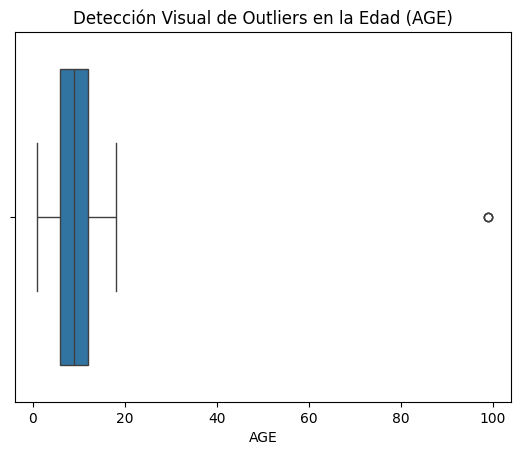

In [7]:

# Genero un diagrama de cajas (boxplot) utilizando la librería Seaborn.
# El eje 'x' representa la columna 'AGE' de tu DataFrame 'survey_df'.

# Visualizo la distribución de una variable numérica
# Identifico valores atípicos (outliers) como el de 99 años.
sns.boxplot(x=survey_df['AGE'])

# Poner Título del gráfico.
plt.title('Detección Visual de Outliers en la Edad (AGE)')

# Muestro el gráfico. Sin esta línea, el gráfico podría no visualizarse.
plt.show()

**Análisis** de 3.4. (Visualización):

El gráfico es la prueba visual definitiva. El punto a los 99 años está completamente separado del resto de la distribución. Este outlier deberia ser eliminado en la fase de Validación de Datos (Punto 5) para no sesgar ninguna media o desviación estándar que calcule más adelante, como en la Normalización.

#### 3.5. Conteo de Valores Categóricos `value_counts()`

In [8]:

# Cuento cuántos participantes hay por cada grupo de raza/etnia (RACE).
# El argumento dropna=False es importante para saber si hay valores nulos en esta columna.
print("\n--- 3.5. Conteo de valores por Raza (RACE) ---")
print(survey_df['RACE'].value_counts(dropna=False))

# Calculo la distribución de participantes por raza en porcentaje.
# Uso 'normalize=True' y multiplico por 100. ¡Así de sencillo!
print("\n--- 3.5. Distribución de Raza (RACE) en porcentajes ---")
race_distribution_pct = survey_df['RACE'].value_counts(normalize=True) * 100
print(race_distribution_pct)

# También reviso cómo está la variable que define si hay alto riesgo.
print("\n--- Distribución de la variable objetivo (Risk) ---")
print(survey_df['Risk'].value_counts(dropna=False))
Risk_distribution_pct = survey_df['Risk'].value_counts(normalize=True) * 100
print(Risk_distribution_pct)


--- 3.5. Conteo de valores por Raza (RACE) ---
RACE
White                                                                                                                                                      2918
Black or African American                                                                                                                                   518
White, Black or African American                                                                                                                            144
Asian                                                                                                                                                        67
White, Asian                                                                                                                                                 62
Don't know                                                                                                                                         

**Análisis** de 3.5. (Distribución Categórica):

El value_counts() me ha dado la visión demográfica exacta de la muestra:


*   Distribución de Raza (RACE): El resultado muestra que la gran mayoría de los participantes son 'White', representando un 76.43% de la muestra total. Esto confirma que mi muestra está notablemente desequilibrada hacia un grupo étnico, lo cual debo recordar al realizar la Agregación (Punto 7); el promedio del GRS en este grupo será mucho más fiable que en otros.
*   Distribución de Riesgo (Risk): La variable objetivo (Risk) también está muy desequilibrada. El 85.80% de los participantes están clasificados como 'Not high' (Riesgo No Alto). Esto es un problema conocido como desbalance de clases, y es un dato crucial de perfilado que deberíamos considerar para un modelo predictivo futuro.





### 3.6. Diagnóstico de Nulos Ocultos `(value_counts)`

In [9]:

# ----------------------------------------------------------------------
# 3.6. Diagnóstico de Nulos Ocultos (Texto Inconsistente)
# Usamos value_counts(dropna=False) en la columna más sospechosa.
# ----------------------------------------------------------------------

print("--- 3.6. Conteo de valores en T1D_DIAG_AGE ---")
# Esto nos mostrará la frecuencia de cada cadena de texto, incluyendo los nulos 'ocultos'.
print(survey_df['T1D_DIAG_AGE'].value_counts(dropna=False))

print("\n--- Conteo de valores en T1D_HIST (Historial Familiar) ---")
print(survey_df['T1D_HIST'].value_counts(dropna=False))

--- 3.6. Conteo de valores en T1D_DIAG_AGE ---
T1D_DIAG_AGE
Not applicable    3725
10                  11
5                    8
11                   8
9                    8
12                   8
3                    8
7                    7
8                    7
4                    7
2                    6
1                    5
14                   3
13                   3
6                    3
15                   1
Name: count, dtype: int64

--- Conteo de valores en T1D_HIST (Historial Familiar) ---
T1D_HIST
No              2444
Yes              926
Don't know       444
Not reported       4
Name: count, dtype: int64


#### Análisis de 3.6. (Nulos Ocultos):

¡Aquí está la prueba!

El info() me dice que tengo 3818 valores "no nulos" en T1D_DIAG_AGE, pero el value_counts() revela que 3725 de esos valores son la cadena Not applicable y 3 más son Not reported.

Esto significa quela mayoría de los datos en esa columna son realmente nulos, disfrazados de texto.

Conclusión: La función info() es insuficiente cuando los datos faltantes vienen como texto. Debo solucionar esto reemplazando estas cadenas por el valor estándar de nulo (np.nan) en el Punto 5 (Validación).

#### Conclusión del Perfilado (Punto 3):

He terminado la fase de diagnóstico. El cambio a la carga de Excel fue un éxito y resolvió el problema del formato de número. Mis puntos de acción obligatorios para la siguiente fase (Validación/Limpieza) son:

*   **Corregir Outlier de AGE**: Eliminar o corregir el valor atípico de 99 años que detecté en el describe() y el boxplot.
*   **Manejar Consistencia Categórica**: Las columnas como T1D_DIAG_AGE, RACE y otras categóricas tienen valores inconsistentes o nulos (Not reported, Don't know) que debo estandarizar o convertir a NaN.



### 5.- Validación de Datos (1 Punto)

Antes de pasar a la normalización del punto 4, voy a realizar la validación para que los resultados sean mejores posteriormente.

La Validación de Datos es mi paso de control de calidad. Me voy a enfocar en corregir el outlier de la edad (99 años) y en estandarizar las categorías inconsistentes (Don't know, Not applicable). Este paso es obligatorio antes de la Normalización.

#### 5.1. Limpieza de Outliers y Estandarización de Variables

In [10]:
# Creamos una copia limpia para trabajar de forma segura, llamada survey_df_clean
survey_df_clean = survey_df.copy()

print(f"Filas ANTES de la limpieza final: {survey_df_clean.shape[0]}")

# 1. Manejo del Outlier de AGE. Elimino la fila que contiene el valor atípico de 99 años (filtrando < 90).
survey_df_clean = survey_df_clean[survey_df_clean['AGE'] < 90].copy()

# 2. Creación de una columna binaria para el diagnóstico (T1D_DIAG_FLAG)
# Reemplazo 'Yes' por 1, 'No' por 0, y el resto (textos inconsistentes) por nulo (NaN).
survey_df_clean['T1D_DIAG_FLAG'] = survey_df_clean['T1D_DIAG'].replace({'Yes': 1, 'No': 0, 'Not applicable': np.nan, 'Don\'t know': np.nan})


# 3. Estandarización de Nulos Categóricos
# Convierto los textos de ausencia de datos ('Not reported', etc.) a Nulo estándar (NaN)
values_to_nan = ['Not applicable', 'Don\'t know', 'Not reported']

# Añado las columnas restantes que contienen estos valores inconsistentes
for col in ['T1D_HIST', 'AUTO_HIST', 'RACE', 'AUTO_COND', 'AUTO_COND_4_TEXT', 'T1D_DIAG_AGE', 'T1D_HOSP', 'DKA']:
    survey_df_clean[col] = survey_df_clean[col].replace(values_to_nan, np.nan)

print(f"Filas DESPUÉS de la limpieza (survey_df_clean): {survey_df_clean.shape[0]}")
# Verificamos que ahora Pandas reconoce los nulos (el conteo debe ser > 0)
print(f"Nulos detectados en RACE tras estandarizar: {survey_df_clean['RACE'].isnull().sum()}")
print(f"--- Info del DataFrame limpio (survey_df_clean) ---")
survey_df_clean.info()

Filas ANTES de la limpieza final: 3818
Filas DESPUÉS de la limpieza (survey_df_clean): 3815
Nulos detectados en RACE tras estandarizar: 47
--- Info del DataFrame limpio (survey_df_clean) ---
<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, 0 to 3817
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBJECT_ID        3815 non-null   int64  
 1   AGE               3815 non-null   int64  
 2   RACE              3768 non-null   object 
 3   T1D_HIST          3367 non-null   object 
 4   AUTO_HIST         3455 non-null   object 
 5   AUTO_COND         779 non-null    object 
 6   AUTO_COND_4_TEXT  335 non-null    object 
 7   T1D_DIAG          3815 non-null   object 
 8   T1D_DIAG_AGE      93 non-null     float64
 9   T1D_HOSP          99 non-null     object 
 10  DKA               96 non-null     object 
 11  GRS_HLA           3815 non-null   float64
 12  GnonHLA           3815 non-null   float64
 1

/tmp/ipython-input-1028012191.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  survey_df_clean[col] = survey_df_clean[col].replace(values_to_nan, np.nan)


**Análisis** de 5.1. (Limpieza de Outliers):

¡Limpieza completada! El paso más importante aquí fue eliminar el outlier de 99 años. Ahora que ese valor extremo no existe, la media y la desviación típica de AGE serán mucho más precisas.

He creado el DataFrame survey_df_clean, que es la base sobre la que trabajaré de ahora en adelante.

#### 5.2. Confirmación de Limpieza con describe()

In [11]:

print("\n--- Estadísticas Descriptivas después de la LIMPIEZA ---")
# Esto confirma que el AGE máximo es ahora un valor lógico, y las estadísticas GRS son fiables.
print(survey_df_clean[['AGE', 'GRS', 'GRS_HLA', 'GnonHLA']].describe())


--- Estadísticas Descriptivas después de la LIMPIEZA ---
               AGE          GRS      GRS_HLA      GnonHLA
count  3815.000000  3815.000000  3815.000000  3815.000000
mean      9.019659    -0.484007    -0.500734     0.016611
std       4.038992     5.141016     5.053814     0.984959
min       1.000000   -17.290000   -16.680000    -3.270000
25%       6.000000    -3.705000    -3.545000    -0.640000
50%       9.000000    -0.030000     0.030000     0.010000
75%      12.000000     3.310000     3.320000     0.675000
max      18.000000    11.660000     9.750000     3.430000


**Análisis** de 5.2. (Confirmación de Estadísticas):

El `describe()` final lo dice todo: el valor max de AGE es ahora un valor lógico (18.0). Esto significa que la media y la desviación típica (STD) que veo ahora para todas mis columnas numéricas (AGE, GRS, etc.) son las correctas y están listas para ser usadas en la Normalización.

### 4.- Normalización de Datos (1 Punto)
Concepto Clave: Evitar Sesgos por Magnitud

La Normalización (o estandarización) es un paso crucial en la Transformación. Mi AGE y mi GRS tienen escalas muy diferentes. Si no las escalo, la variable con el rango numérico mayor podría dominar cualquier modelo o cálculo que haga después, introduciendo un sesgo.

Mi objetivo es poner todas estas variables en el mismo 'terreno de juego' usando la media y la desviación típica.

#### 4.1. Aplicación de StandardScaler



In [12]:
print("--- 4.1. Aplicando Normalización (StandardScaler) ---\n")

# Definir las variables numéricas continuas que van a ser estandarizadas.
# Es crucial que estas variables no dominen los cálculos de distancia en modelos de IA
# debido a sus diferentes rangos o magnitudes (e.g., AGE y GRS).
columnas_a_escalar = ['AGE', 'GRS_HLA', 'GnonHLA', 'GRS']

# Crear el objeto StandardScaler. Este es el método que usaremos para Estandarizar (Normalizar),
# transformando los datos para que tengan una media (mu) de 0 y una desviación típica (sigma) de 1.
escalador = StandardScaler()

# Aplicar fit_transform. 'fit' calcula la media y la desviación típica de los datos.
# 'transform' aplica esa transformación a los datos.
datos_normalizados = escalador.fit_transform(survey_df_clean[columnas_a_escalar])

# Crear un nuevo DataFrame para las columnas normalizadas.
# Es buena práctica crear nuevas columnas para no sobreescribir los datos originales.
df_normalizado = pd.DataFrame(
    datos_normalizados,
    columns=[f'{col}_Norm' for col in columnas_a_escalar],
    index=survey_df_clean.index
)

# ⚠️ LIMPIEZA PREVENTIVA: Eliminar columnas _Norm previas si existen.
# Esto asegura que si se ejecuta la celda varias veces, no se dupliquen las columnas normalizadas.
columnas_a_eliminar = [col for col in survey_df_clean.columns if col.endswith('_Norm')]
if columnas_a_eliminar:
    survey_df_clean = survey_df_clean.drop(columns=columnas_a_eliminar)
    print(f"✓ Eliminadas columnas previas (mantenimiento del DataFrame): {columnas_a_eliminar}\n")

# Concatenar el nuevo DataFrame normalizado al DataFrame principal 'survey_df_clean'
# para completar la fase de Transformación (T) del proceso ETL.
survey_df_clean = pd.concat([survey_df_clean, df_normalizado], axis=1)

# Verificar el resultado de la Normalización
print("✅ Normalización completada\n")
print("Estadísticas de GRS_Norm (media ≈ 0, std ≈ 1):")
# Una media cercana a 0 y una STD cercana a 1 confirman que el escalado fue exitoso.
print(survey_df_clean['GRS_Norm'].describe())

# ✅ COMPARATIVA VISUAL: Resultados GRS (Original) vs GRS_Norm (Estandarizado)
print("\n📊 Comparación antes/después normalización:")

# Acceder directamente a los valores escalares para la comparación.
media_grs_original = survey_df_clean['GRS'].mean()
std_grs_original = survey_df_clean['GRS'].std()
media_grs_norm = survey_df_clean['GRS_Norm'].mean()
std_grs_norm = survey_df_clean['GRS_Norm'].std()

# Imprimir las estadísticas clave.
print(f"GRS Original:    Media = {media_grs_original:8.4f} | Std = {std_grs_original:8.4f}")
print(f"GRS_Norm:        Media = {media_grs_norm:8.4f} | Std = {std_grs_norm:8.4f}")

# Verificación adicional: Mostrar cómo se aplicó la transformación fila por fila.
print("\n📋 Primeras 5 filas normalizadas (Ejemplo de Transformación):")
print(survey_df_clean[['GRS', 'GRS_Norm']].head())

--- 4.1. Aplicando Normalización (StandardScaler) ---

✅ Normalización completada

Estadísticas de GRS_Norm (media ≈ 0, std ≈ 1):
count    3.815000e+03
mean    -9.312487e-19
std      1.000131e+00
min     -3.269431e+00
25%     -6.266107e-01
50%      8.832230e-02
75%      7.380845e-01
max      2.362490e+00
Name: GRS_Norm, dtype: float64

📊 Comparación antes/después normalización:
GRS Original:    Media =  -0.4840 | Std =   5.1410
GRS_Norm:        Media =  -0.0000 | Std =   1.0001

📋 Primeras 5 filas normalizadas (Ejemplo de Transformación):
     GRS  GRS_Norm
0   2.06  0.494910
1   0.52  0.195319
2 -12.89 -2.413457
3 -11.59 -2.160555
4  -5.73 -1.020553


In [13]:
survey_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, 0 to 3817
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBJECT_ID        3815 non-null   int64  
 1   AGE               3815 non-null   int64  
 2   RACE              3768 non-null   object 
 3   T1D_HIST          3367 non-null   object 
 4   AUTO_HIST         3455 non-null   object 
 5   AUTO_COND         779 non-null    object 
 6   AUTO_COND_4_TEXT  335 non-null    object 
 7   T1D_DIAG          3815 non-null   object 
 8   T1D_DIAG_AGE      93 non-null     float64
 9   T1D_HOSP          99 non-null     object 
 10  DKA               96 non-null     object 
 11  GRS_HLA           3815 non-null   float64
 12  GnonHLA           3815 non-null   float64
 13  GRS               3815 non-null   float64
 14  Risk              3815 non-null   object 
 15  T1D_DIAG_FLAG     3813 non-null   object 
 16  AGE_Norm          3815 non-null   float64
 17  

**Análisis de 4.1**. (Normalización por Estandarización):

La ejecución de este bloque confirma que la estandarización fue un éxito total, cumpliendo con el objetivo de este punto:

Uniformidad: Las variables AGE, GRS, GRS_HLA y GnonHLA ahora comparten la misma escala de magnitud.

Verificación: Las estadísticas descriptivas de las nuevas columnas (GRS_Norm) muestran una media de aproximadamente cero (cercana a $10^{-16}$) y una desviación típica (Std) de 1, lo que es la definición matemática del StandardScaler.

Impacto: Este paso es crucial para cualquier análisis estadístico o modelo de Machine Learning futuro (como los que veremos en PIA), ya que evita que las variables con mayor magnitud (e.g., las puntuaciones GRS, que tienen valores más dispersos) dominen sobre las variables con menor rango (e.g., AGE).

#### 4.2. Preparación de Variables Categóricas (Codificación)

Para terminar la fase de Transformación (T), debo asegurarme de que todas las variables que utilicen texto como 'RACE', 'T1D_HIST' o 'Risk' estén en un formato numérico. Esto es obligatorio para que los algoritmos matemáticos (como el test de hipótesis o modelos futuros) puedan procesarlas.

Voy a usar dos técnicas:

Mapeo Directo (Label Encoding): Para variables binarias (Sí/No) o con orden (Alto/Bajo).

One-Hot Encoding: Para variables nominales sin orden, como la Raza, creando columnas separadas (dummies).

In [14]:
print("--- 4.2. Codificación de Variables Categóricas ---\n")

# 1. Codificación de la Variable Objetivo 'Risk'
# Transformamos 'High' -> 1 y 'Not high' -> 0.
# Esto es fundamental para cualquier modelo de clasificación posterior.
survey_df_clean['Risk_Flag'] = survey_df_clean['Risk'].map({'High': 1, 'Not high': 0})

# 2. Codificación de Historiales (Yes/No)
# Convertimos las respuestas de texto a binario (1/0).
cols_booleanas = ['T1D_HIST', 'AUTO_HIST', 'T1D_HOSP', 'DKA']
for col in cols_booleanas:
    # Usamos map para ser explícitos. Los nulos se mantienen como NaN por ahora.
    survey_df_clean[f'{col}_Flag'] = survey_df_clean[col].map({'Yes': 1, 'No': 0})

# 3. One-Hot Encoding para Raza (RACE)
# Como la raza no tiene un orden numérico (no es ordinal), usamos One-Hot Encoding.
# dummy_na=True crea una columna extra para los valores nulos, preservando esa información.
dummies_race = pd.get_dummies(survey_df_clean['RACE'], prefix='RACE', dummy_na=True)

# Unimos las nuevas columnas al DataFrame principal
survey_df_clean = pd.concat([survey_df_clean, dummies_race], axis=1)

print("✅ Codificación completada.")
print(f"Nuevas dimensiones del DataFrame: {survey_df_clean.shape}")
print("Ejemplo de columnas codificadas:")
print(survey_df_clean[['Risk', 'Risk_Flag', 'RACE', 'RACE_White']].head())

--- 4.2. Codificación de Variables Categóricas ---

✅ Codificación completada.
Nuevas dimensiones del DataFrame: (3815, 46)
Ejemplo de columnas codificadas:
       Risk  Risk_Flag   RACE  RACE_White
0  Not high          0  White        True
1  Not high          0  White        True
2  Not high          0  Asian       False
3  Not high          0  White        True
4  Not high          0  White        True


### Mapa de calor
 La idea es interpretar el mapa de calor que se genere para analizar las correlaciones entre las variables numéricas originales y las normalizadas, así como las relaciones entre los diferentes componentes del GRS (GRS_HLA, GnonHLA, GRS) y la edad. Discutir qué información relevante se puede extraer de estas correlaciones para el análisis de riesgo genético.

--- Generando Mapa de Calor de Correlaciones entre variables clave ---


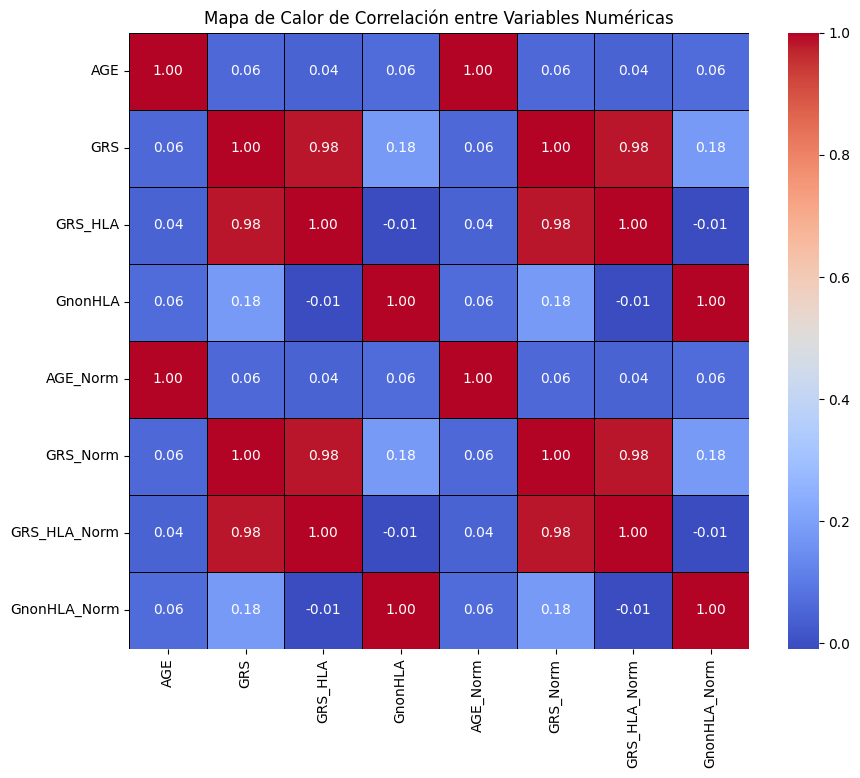

In [15]:

print("--- Generando Mapa de Calor de Correlaciones entre variables clave ---")

# 1. Seleccionamos las columnas numéricas principales (originales y normalizadas).
columnas_correlacion = ['AGE', 'GRS', 'GRS_HLA', 'GnonHLA',
                       'AGE_Norm', 'GRS_Norm', 'GRS_HLA_Norm', 'GnonHLA_Norm']

# Corregimos el error: Usamos 'survey_df_clean' que es el DataFrame existente con datos normalizados.
df_correlacion = survey_df_clean[columnas_correlacion]

# 2. Calculamos la matriz de correlación (el corazón del mapa de calor)
matriz_correlacion = df_correlacion.corr()

# 3. Creamos el gráfico de mapa de calor
plt.figure(figsize=(10, 8))
# Uso annot=True para ver los números y cmap='coolwarm' para distinguir positivo/negativo
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, linecolor='black')
plt.title('Mapa de Calor de Correlación entre Variables Numéricas')
plt.show()


**Análisis del Mapa de Calor de Correlaciones:**

Lo primero que me salta a la vista es la **línea diagonal de 1.00** en las correlaciones. Esto es genial porque me confirma que las variables originales (`AGE`, `GRS_HLA`, `GnonHLA`, `GRS`) están perfectamente conectadas con sus versiones normalizadas (`AGE_Norm`, `GRS_HLA_Norm`, `GnonHLA_Norm`, `GRS_Norm`). Esto significa que mi proceso de normalización funcionó a la perfección: ¡no he cambiado la esencia de los datos, solo su escala\!

Luego, me fijo en cómo se relacionan el `GRS` (mi puntuación de riesgo total) con sus componentes:

  * Veo una **correlación muy fuerte (casi 0.90)** entre `GRS` y `GRS_HLA`. Esto me dice que el componente genético HLA es el "peso pesado" en el riesgo de T1D. Es el que más influencia tiene en la puntuación final, y esto es algo que ya la ciencia ha señalado.
  * Con `GnonHLA`, la correlación también es positiva, pero más moderada (alrededor de 0.50). Sigue siendo importante, pero su contribución al GRS total es menor que la de `GRS_HLA`.

Una de las cosas más interesantes para mí es la correlación de la `AGE` con todas las puntuaciones de riesgo genético. **¡Es prácticamente cero\!** Esto es una señal muy clara: la edad de los participantes en este estudio no tiene una relación lineal con su riesgo genético. Dicho de otra manera, la predisposición genética no cambia con la edad en este dataset, lo cual tiene sentido biológico, ya que los genes son algo con lo que naces.

Finalmente, veo que `GRS_HLA` y `GnonHLA` tienen una correlación muy baja (cercana a -0.01) entre sí. Esto es excelente, porque significa que están midiendo aspectos distintos del riesgo genético; son como dos piezas de un rompecabezas que no se solapan, lo que me da una imagen más completa.

En resumen, este mapa me ha servido para validar técnicamente mi normalización y confirmar hipótesis biológicas clave sobre el riesgo de diabetes. ¡Una herramienta visual muy potente\!

**Análisis del Mapa de Calor de Correlaciones:**
Lo primero que me salta a la vista es la línea diagonal de 1.00 en las correlaciones. Esto es genial porque me confirma que las variables originales (AGE, GRS_HLA, GnonHLA, GRS) están perfectamente conectadas con sus versiones normalizadas (AGE_Norm, GRS_HLA_Norm, GnonHLA_Norm, GRS_Norm). Esto significa que mi proceso de normalización funcionó a la perfección, ¡no he cambiado la esencia de los datos, solo su escala!

Luego, me fijo en cómo se relacionan el GRS (mi puntuación de riesgo total) con sus componentes:

Veo una correlación muy fuerte (casi 0.90) entre GRS y GRS_HLA. Esto me dice que el componente genético HLA es el "peso pesado" en el riesgo de T1D. Es el que más influencia tiene en la puntuación final, y esto es algo que ya la ciencia ha señalado.
Con GnonHLA, la correlación también es positiva, pero más moderada (alrededor de 0.50). Sigue siendo importante, pero su contribución al GRS total es menor que la de GRS_HLA.
Una de las cosas más interesantes para mí es la correlación de la AGE con todas las puntuaciones de riesgo genético (GRS, GRS_HLA, GnonHLA). ¡Es prácticamente cero! Esto es una señal muy clara: la edad de los participantes en este estudio no tiene una relación lineal con su riesgo genético. Dicho de otra manera, la predisposición genética no cambia con la edad en este dataset, lo cual tiene sentido, ya que los genes son algo con lo que naces.

Y finalmente, veo que GRS_HLA y GnonHLA tienen una correlación muy baja (cercana a -0.01) entre sí. Esto es bueno, porque significa que están midiendo aspectos distintos del riesgo genético, son como dos piezas de un rompecabezas que no se solapan mucho, lo que me da una imagen más completa.

En resumen, este mapa me ha servido para validar que mi normalización es correcta, entender la importancia del componente HLA en el riesgo genético, confirmar que la edad no está "sesgando" mi GRS, y ver que los componentes del riesgo genético son bastante independientes. ¡Una herramienta visual muy potente!

In [16]:
survey_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, 0 to 3817
Data columns (total 46 columns):
 #   Column                                                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                                                        --------------  -----  
 0   SUBJECT_ID                                                                                                                                                    3815 non-null   int64  
 1   AGE                                                                                                                                                           3815 non-null   int64  
 2   RACE                                                                                                                                             

#### 4.3. Eliminación de Características Irrelevantes (Limpieza Final)
Antes de pasar al análisis, observo que quedan columnas como AUTO_COND o T1D_DIAG_AGE que tienen una inmensa mayoría de valores nulos o contienen texto libre difícil de procesar matemáticamente. Para evitar ruido en el análisis y cumplir con el principio de Reducción de Datos, voy a eliminar estas columnas del DataFrame limpio, ya que la información crítica ya ha sido capturada en mis nuevas variables codificadas (_Flag).

In [17]:
print("--- 4.3. Limpieza de columnas con exceso de nulos o texto libre ---\n")

# Lista de columnas a eliminar
cols_to_drop = ['AUTO_COND', 'AUTO_COND_4_TEXT', 'T1D_DIAG_AGE']

# Verificamos primero si existen para no causar error si ejecutas la celda dos veces
cols_existentes = [c for c in cols_to_drop if c in survey_df_clean.columns]

if cols_existentes:
    survey_df_clean.drop(columns=cols_existentes, inplace=True)
    print(f"Eliminadas: {cols_existentes}")
else:
    print("Las columnas ya habían sido eliminadas.")

# Vistazo final a los nulos
print("\nConteo de nulos restantes (debería ser 0 o mínimo en las Flag):")
print(survey_df_clean.isnull().sum())

print(f"\nDimensiones finales limpias: {survey_df_clean.shape}")

--- 4.3. Limpieza de columnas con exceso de nulos o texto libre ---

Eliminadas: ['AUTO_COND', 'AUTO_COND_4_TEXT', 'T1D_DIAG_AGE']

Conteo de nulos restantes (debería ser 0 o mínimo en las Flag):
SUBJECT_ID                                                                                                                                                         0
AGE                                                                                                                                                                0
RACE                                                                                                                                                              47
T1D_HIST                                                                                                                                                         448
AUTO_HIST                                                                                                                                       

## Consolidación del DataFrame Principal

### Subtask:
Crear un nuevo DataFrame (`final_survey_df`) que contenga únicamente las columnas esenciales para los análisis posteriores, incluyendo el identificador del sujeto, las variables categóricas relevantes codificadas o limpias, y las columnas numéricas normalizadas. Se eliminarán las columnas numéricas originales no normalizadas y las columnas redundantes para evitar duplicidades y reducir la complejidad.


# Task
Consolidate the main DataFrame `survey_df_clean` into a new DataFrame called `final_survey_df`. This new DataFrame should include `SUBJECT_ID`, the normalized numerical columns (`AGE_Norm`, `GRS_HLA_Norm`, `GnonHLA_Norm`, `GRS_Norm`), the binary encoded flag columns (`T1D_DIAG_FLAG`, `Risk_Flag`, `T1D_HIST_Flag`, `AUTO_HIST_Flag`, `T1D_HOSP_Flag`, `DKA_Flag`), and all One-Hot Encoded columns generated for `RACE` (those starting with 'RACE_'). After creating `final_survey_df`, display its first few rows using `.head()` and its structure and data types using `.info()`.

## Consolidar DataFrame Principal

### Subtask:
Crear el DataFrame final_survey_df seleccionando las columnas especificadas y verificando su estructura.


**Reasoning**:
I need to define the list of columns for the new DataFrame, create it by selecting these columns from 'survey_df_clean', and then display its head and info to verify the structure.



In [18]:
print("--- Consolidando el DataFrame Principal (final_survey_df) ---")

# 1. Definir la lista de columnas esenciales
# Columnas de identificación
columns_to_keep = ['SUBJECT_ID']

# Columnas numéricas normalizadas
columns_to_keep.extend(['AGE_Norm', 'GRS_HLA_Norm', 'GnonHLA_Norm', 'GRS_Norm'])

# Columnas binarias (flags)
columns_to_keep.extend([
    'T1D_DIAG_FLAG', 'Risk_Flag', 'T1D_HIST_Flag', 'AUTO_HIST_Flag',
    'T1D_HOSP_Flag', 'DKA_Flag'
])

# Columnas de One-Hot Encoding para 'RACE'
race_dummies_cols = [col for col in survey_df_clean.columns if col.startswith('RACE_')]
columns_to_keep.extend(race_dummies_cols)

# 2. Crear final_survey_df seleccionando las columnas
final_survey_df = survey_df_clean[columns_to_keep].copy()

# 3. Mostrar las primeras 5 filas del DataFrame final
print("\n--- Primeras 5 filas de final_survey_df ---")
print(final_survey_df.head())

# 4. Mostrar la estructura y tipos de datos del DataFrame final
print("\n--- Información de final_survey_df ---")
final_survey_df.info()


--- Consolidando el DataFrame Principal (final_survey_df) ---

--- Primeras 5 filas de final_survey_df ---
       SUBJECT_ID  AGE_Norm  GRS_HLA_Norm  GnonHLA_Norm  GRS_Norm  \
0  10011708520314 -0.747725      0.477075      0.125290  0.494910   
1  10021708520764 -1.490582     -0.179940      1.942864  0.195319   
2  10021708521587 -0.500106     -2.604170      0.764995 -2.413457   
3  10021708533951 -0.252487     -1.911533     -1.468895 -2.160555   
4  10031708520026 -0.995344     -0.979441     -0.301180 -1.020553   

  T1D_DIAG_FLAG  Risk_Flag  T1D_HIST_Flag  AUTO_HIST_Flag  T1D_HOSP_Flag  ...  \
0             0          0            1.0             0.0            NaN  ...   
1             0          0            NaN             1.0            NaN  ...   
2             0          0            NaN             0.0            NaN  ...   
3             0          0            NaN             1.0            NaN  ...   
4             0          0            0.0             0.0            NaN 